In [1]:
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import squareform, pdist
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [2]:
# modified from Alex Williams' blog (NYU + Flatiron Institute)
# https://alexhwilliams.info/itsneuronalblog/2020/10/09/optimal-transport/

def demo_wasserstein(x, p, q):
    """
    Computes order-2 Wasserstein distance between two
    discrete distributions defined over the same support using Scipy's linprog.

    Parameters
    ----------
    x : ndarray, has shape (num_bins, dimension)
    
        Locations of discrete atoms (or "spatial bins")

    p : ndarray, has shape (num_bins,)

        Probability mass of the first distribution on each atom.

    q : ndarray, has shape (num_bins,)

        Probability mass of the second distribution on each atom.

    Returns
    -------
    dist : float

        The Wasserstein distance between the two distributions.

    T : ndarray, has shape (num_bins, num_bins)

        Optimal transport plan. Satisfies p == T.sum(axis=0)
        and q == T.sum(axis=1).

    Note
    ----
    This function is meant for demo purposes only and is not
    optimized for speed. It should still work reasonably well
    for moderately sized problems.
    """

    # Check inputs.
    if (abs(p.sum() - 1) > 1e-9) or (abs(p.sum() - q.sum()) > 1e-9):
        raise ValueError("Expected normalized probability masses.")

    if np.any(p < 0) or np.any(q < 0):
        raise ValueError("Expected nonnegative mass vectors.")

    if (x.shape[0] != p.size) or (p.size != q.size):
        raise ValueError("Dimension mismatch.")

    # Compute pairwise costs between all xs. (Euclidean)
    n, d = x.shape
    C = squareform(pdist(x, metric="sqeuclidean"))

    # Scipy's linear programming solver will accept the problem in
    # the following form:
    # 
    # minimize     c @ t        over t
    # subject to   A @ t == b
    #
    # where we specify the vectors c, b and the matrix A as parameters.

    # Construct matrices Ap and Aq encoding marginal constraints.
    # We want (Ap @ t == p) and (Aq @ t == q).
    Ap, Aq = [], []
    z = np.zeros((n, n))
    z[:, 0] = 1

    for i in range(n):
        Ap.append(z.ravel())
        Aq.append(z.transpose().ravel())
        z = np.roll(z, 1, axis=1)

    # We can leave off the final constraint, as it is redundant.
    # See Remark 3.1 in Peyre & Cuturi (2019).
    A = np.vstack((Ap, Aq))[:-1]
    b = np.concatenate((p, q))[:-1]

    # Solve linear program, recover optimal vector t.
    result = linprog(C.ravel(), A_eq=A, b_eq=b)

    # Reshape optimal vector into (n x n) transport plan matrix T.
    T = result.x.reshape((n, n))

    # Return Wasserstein distance and transport plan.
    return np.sqrt(np.sum(T * C)), T
    

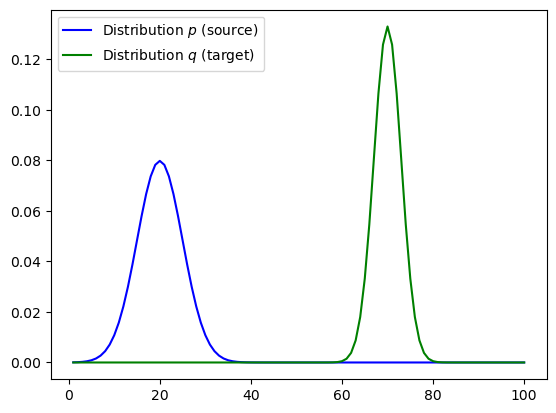

In [6]:
# Define and plot two distributions

x = np.linspace(1,100,100)
rv1 = norm(loc = 20., scale = 5.0)
rv2 = norm(loc = 40, scale = 7.0) 
rv3 = norm(loc = 70., scale = 3)
p = rv1.pdf(x) + 0*rv2.pdf(x)
q = 0*rv2.pdf(x) + rv3.pdf(x)
p /= p.sum()
q /= q.sum()
plt.plot(x,p, label = 'Distribution $p$ (source)')
plt.plot(x,q, label = 'Distribution $q$ (target)')
plt.legend()
x = np.reshape(x, (-1, 1))

In [7]:
d,TP = demo_wasserstein(x, p, q)
print(f'Wasserstein distance between p and q is {d}')

Wasserstein distance between p and q is 50.04073869162763


Text(0.5, 1.0, 'Transport plan')

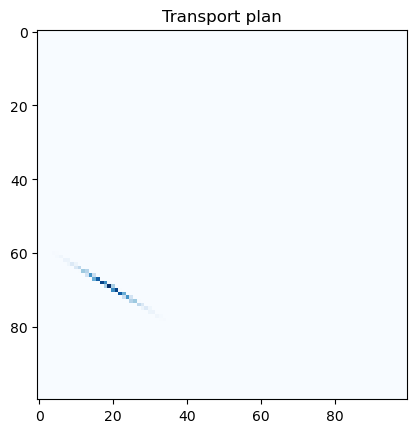

In [8]:
plt.imshow(TP, cmap='Blues')
plt.title('Transport plan')


### Remark
The optimal transport between two Gaussians is linear (under the Euclidean cost)